#### [ Pytorch기반 회귀 모델 구현 ]
- Layer => Full-Connected Layer, Linear
- 손실함수 => MSELoss, MAELoss...

- [1] 데이터 준비 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
filepath = '../data/csv/BostonHousing.csv'
DF = pd.read_csv(filepath)
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [4]:
featureDF = DF[DF.columns[:-1]]
targetDF = DF[DF.columns[-1]]

In [21]:
torch.random.manual_seed(40)

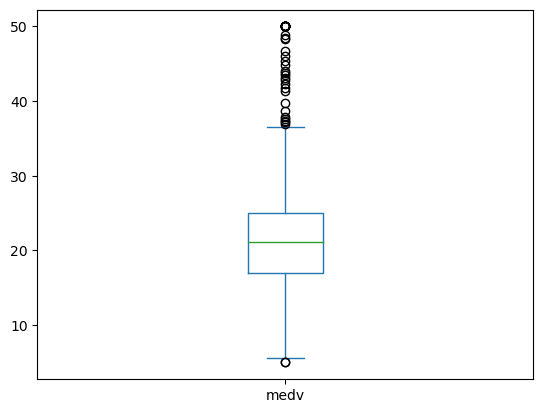

In [14]:
targetDF.plot(kind='box')
plt.show()

In [ ]:
for f in featureDF.columns:
    plt.scatter(featureDF[f], targetDF)
    plt.title(f)
    plt.xlabel(f)
    plt.ylabel('target')
    plt.grid(alpha=0.35)
    plt.show()

- [2] 사용자 데이터셋 클래스 정의

In [15]:
### ===> 클래스 정의
class BostonDS(Dataset):

    ## 데이터 전처리 => 정규화, 텐서화
    def __init__(self, x, y) -> None:
        super().__init__()
        self.feature = torch.FloatTensor(x)
        self.target = torch.FloatTensor(y)
        self.length = self.feature.shape[0]
        self.norm_feature = self.normalization()

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.feature[index], self.target[index]
    
    def normalization(self):
        self.feature.max(dim=1)

In [16]:
class CustomModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [20]:
DS = BostonDS(featureDF.values, targetDF)
DS[0]

(tensor([6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01, 6.5750e+00,
         6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02, 1.5300e+01, 3.9690e+02,
         4.9800e+00]),
 tensor(24.))

In [22]:
trainDS, testDS = random_split(DS, [0.8, 0.2])

In [38]:
BATCH_SIZE = 50
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE,
                     shuffle=True, drop_last=True)
testDL = DataLoader(testDS, batch_size=BATCH_SIZE,
                     shuffle=True, drop_last=True)

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomModel(13, 1)
optim = torch.optim.Adam(model.parameters())
cost_fn = nn.functional.mse_loss
epochs = 1000
schd = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)

In [48]:
train_cost_list = []
valid_cost_list = []

In [49]:
def train(model, optim, epochs, trainDL, validDL):
    for e in range(1, epochs+1):
        model.train()
        for f, t in trainDL:
            h = model(f)

            train_cost = cost_fn(h, t)

            optim.zero_grad()
            train_cost.backward()
            optim.step()

        model.eval()
        for f, t in validDL:
            h = model(f)

            valid_cost = cost_fn(h, t)

        schd.step(valid_cost)
    
        print(f'Epoch : {e:3} --- ')
        print(f'Train cost : {train_cost} Valid cost : {valid_cost}')
        train_cost_list.append(train_cost.item())
        valid_cost_list.append(valid_cost.item())


In [50]:
train(model, optim, epochs, trainDL, testDL)

C:\Users\kdp\AppData\Local\Temp\ipykernel_14128\1582077756.py:7: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  train_cost = cost_fn(h, t)
C:\Users\kdp\AppData\Local\Temp\ipykernel_14128\1582077756.py:17: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  valid_cost = cost_fn(h, t)


Epoch :   1 --- 
Train cost : 54.829769134521484 Valid cost : 83.67650604248047
Epoch :   2 --- 
Train cost : 61.71437454223633 Valid cost : 84.79334259033203
Epoch :   3 --- 
Train cost : 117.98947143554688 Valid cost : 134.9434356689453
Epoch :   4 --- 
Train cost : 89.09282684326172 Valid cost : 98.56314086914062
Epoch :   5 --- 
Train cost : 143.0528564453125 Valid cost : 75.24359893798828
Epoch :   6 --- 
Train cost : 94.83222198486328 Valid cost : 95.98162841796875
Epoch :   7 --- 
Train cost : 92.54630279541016 Valid cost : 122.70198822021484
Epoch :   8 --- 
Train cost : 77.5211410522461 Valid cost : 73.50606536865234
Epoch :   9 --- 
Train cost : 63.379276275634766 Valid cost : 92.54039001464844
Epoch :  10 --- 
Train cost : 76.16261291503906 Valid cost : 108.60582733154297
Epoch :  11 --- 
Train cost : 123.07428741455078 Valid cost : 129.73753356933594
Epoch :  12 --- 
Train cost : 85.19457244873047 Valid cost : 63.11286163330078
Epoch :  13 --- 
Train cost : 89.1680679321289

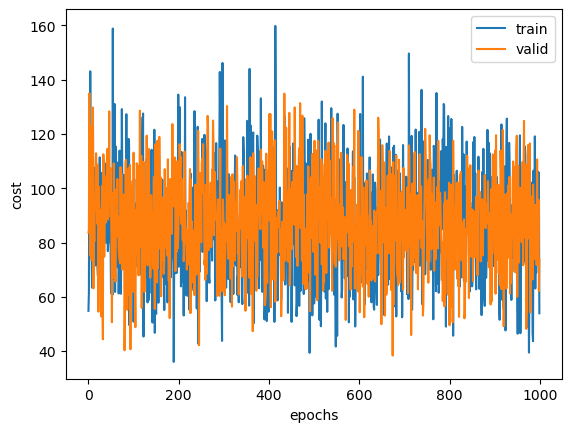

In [51]:
plt.plot(train_cost_list)
plt.plot(valid_cost_list)
plt.legend(['train', 'valid'])
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()